
# ARIMA and Seasonal ARIMA


## Autoregressive Integrated Moving Averages

The general process for ARIMA models is the following:
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model or Seasonal ARIMA based on the data
* Use the model to make predictions

Let's go through these steps!

In [169]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

In [170]:
df=pd.read_csv('/content/perrin-freres-monthly-champagne.csv')

In [171]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [172]:
df.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [173]:
## Cleaning up the data
df.columns=["Month","Sales"]
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [174]:
## Drop last 2 rows
df.drop(106,axis=0,inplace=True)

In [175]:
df.tail()

,Month,Sales
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN


In [176]:
df.drop(105,axis=0,inplace=True)

In [177]:
df.tail()

,Month,Sales
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


In [178]:
# Convert Month into Datetime
df['Month']=pd.to_datetime(df['Month'])

In [179]:
df.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [180]:
df.set_index('Month',inplace=True)

In [181]:
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [182]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


In [183]:
temp_data=df.copy()
temp_data.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


## Step 2: Visualize the Data

<Axes: xlabel='Month'>

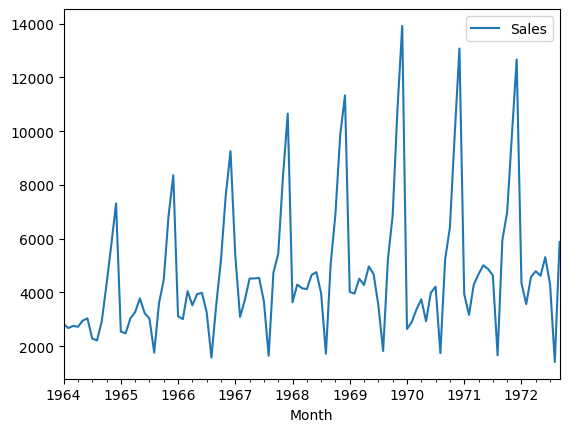

In [184]:
df.plot()

In [185]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [186]:
test_result=adfuller(df['Sales'])

In [187]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [188]:
adfuller_test(df['Sales'])

ADF Test Statistic : -1.8335930563276215
p-value : 0.36391577166024586
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


## Differencing

In [189]:
df['Sales First Difference'] = df['Sales'] - df['Sales'].shift(1)

In [190]:
df['Sales'].shift(1)

,Sales
Month,
1964-01-01,NaN
1964-02-01,2815.0
1964-03-01,2672.0
1964-04-01,2755.0
1964-05-01,2721.0
...,...
1972-05-01,4788.0
1972-06-01,4618.0
1972-07-01,5312.0


In [191]:
df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12)

In [192]:
df.head(14)

,Sales,Sales First Difference,Seasonal First Difference
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


In [193]:
## Again test dickey fuller test
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.626619157213166
p-value : 2.0605796968136632e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Month'>

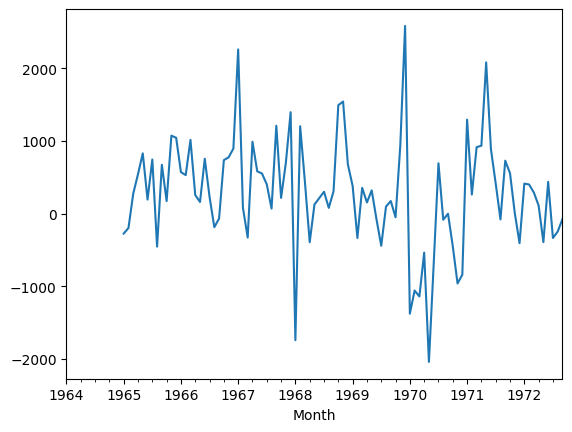

In [194]:
df['Seasonal First Difference'].plot()

## Auto Regressive Model
![image.png](attachment:image.png)

In [195]:
!pip install pandas.tools

ERROR: Could not find a version that satisfies the requirement pandas.tools (from versions: none)
ERROR: No matching distribution found for pandas.tools


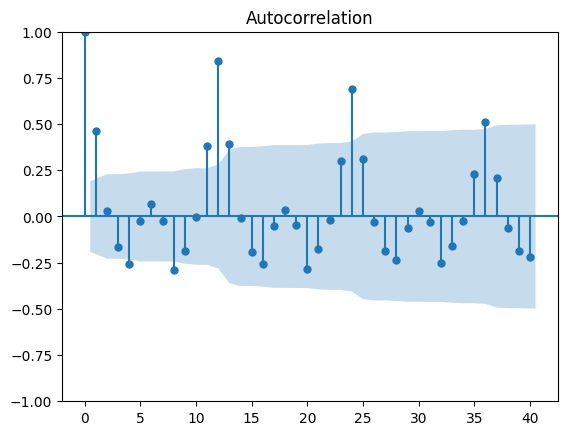

In [196]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(df['Sales'], lags=40)
plt.show()

### Final Thoughts on Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.
    
    p,d,q
    p AR model lags
    d differencing
    q MA lags

In [197]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

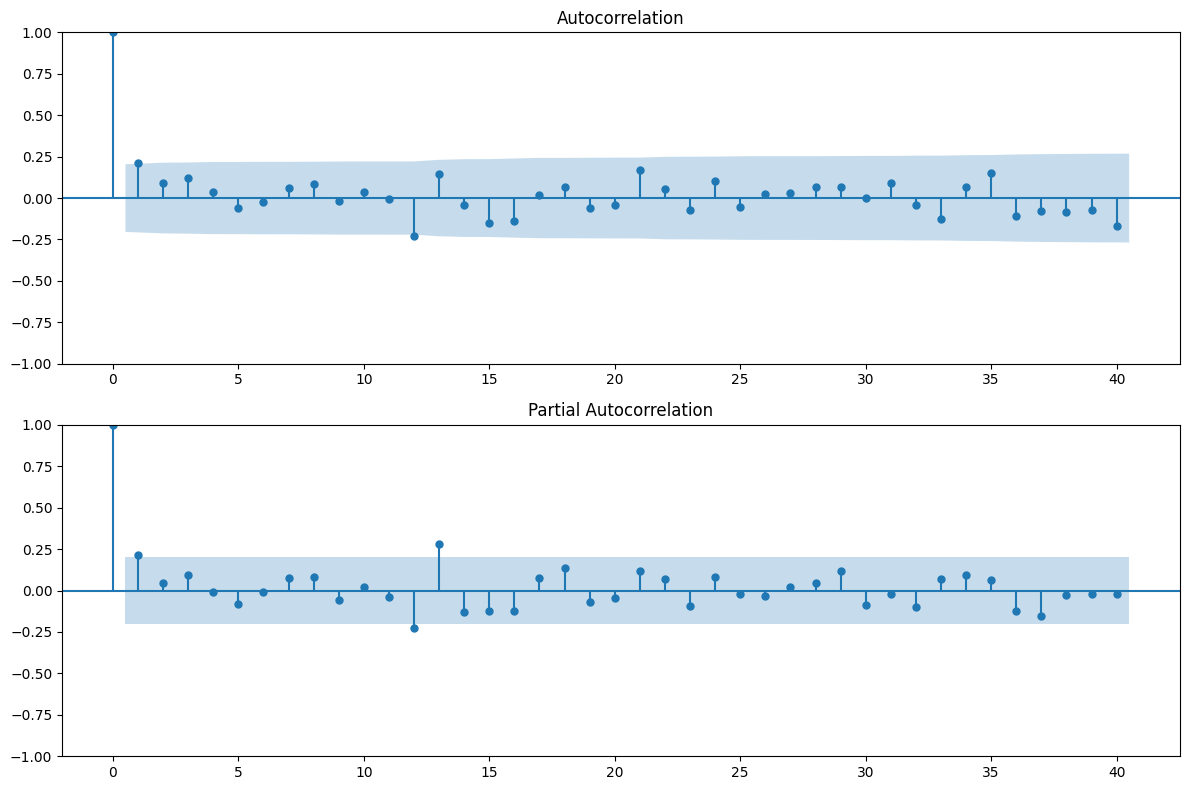

In [198]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(
    df['Seasonal First Difference'].iloc[13:],
    lags=40,
    ax=ax1
)

ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(
    df['Seasonal First Difference'].iloc[13:],
    lags=40,
    ax=ax2
)

plt.tight_layout()
plt.show()



In [199]:
# For non-seasonal data
#p=1, d=1, q=0 or 1

In [200]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['Sales'], order=(1, 1, 1))
model_fit = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [201]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Fri, 26 Dec 2025   AIC                           1911.627
Time:                        18:46:23   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      4.000      0.000       0.232       0.677
ma.L1         -0.9666      0.056    -17.319      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.473      0.000    4.02e+06    6.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.34   Prob(JB):                         0.27
Heteroskedasticity (H):               3.40   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Month'>

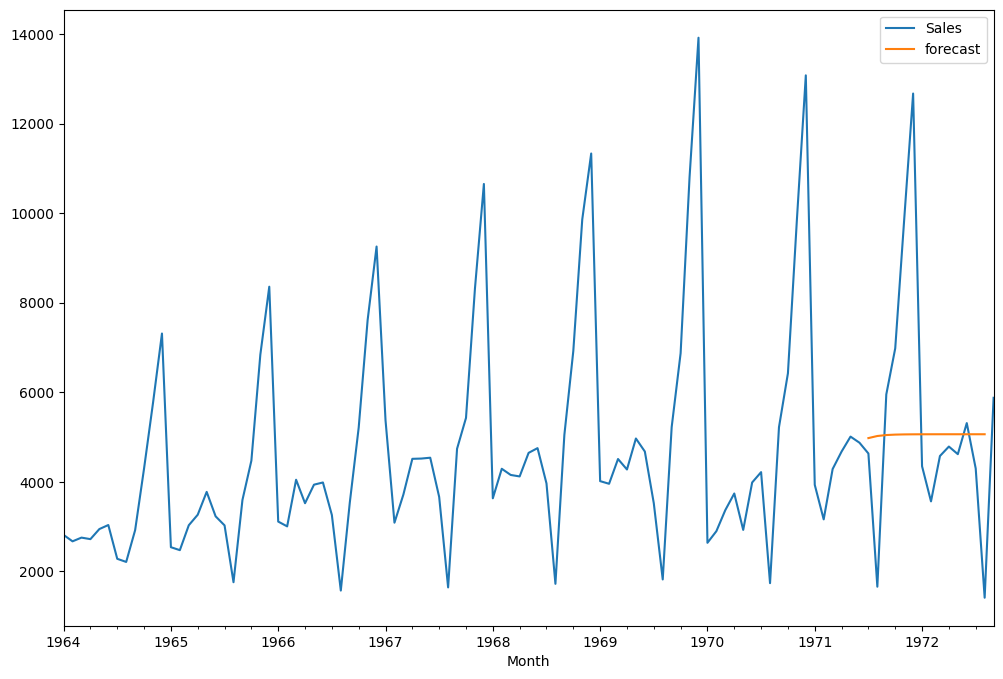

In [202]:
df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

In [203]:
import statsmodels.api as sm

In [204]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Month'>

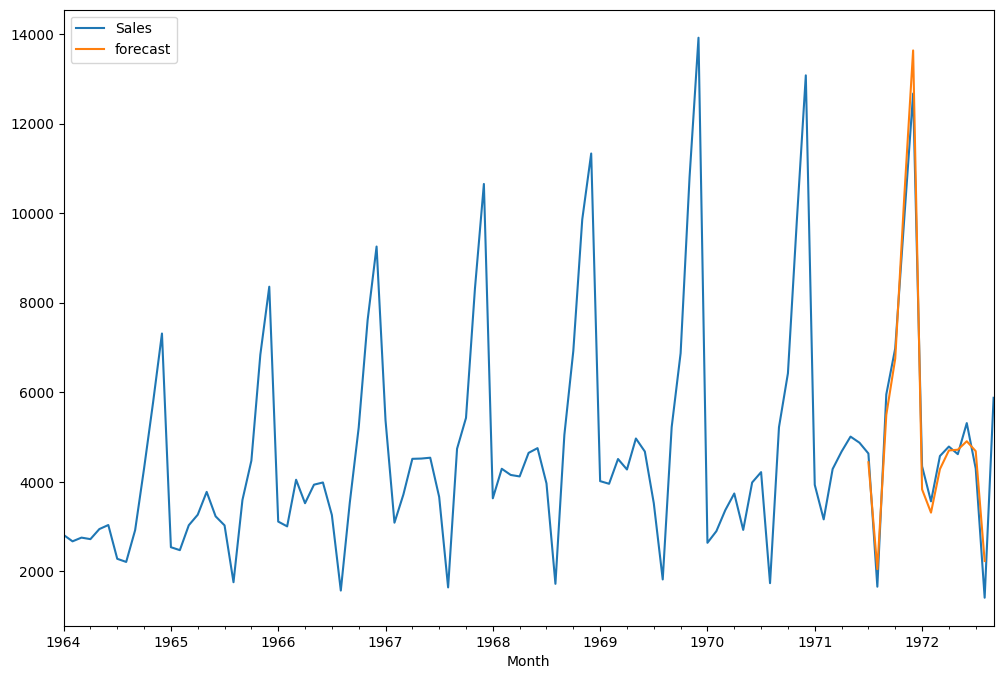

In [205]:
df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

In [206]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [207]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [208]:
future_datest_df.tail()

,Sales,Sales First Difference,Seasonal First Difference,forecast
1974-04-01,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN


In [209]:
future_df=pd.concat([df,future_datest_df])

/tmp/ipython-input-1723908026.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df=pd.concat([df,future_datest_df])


<Axes: >

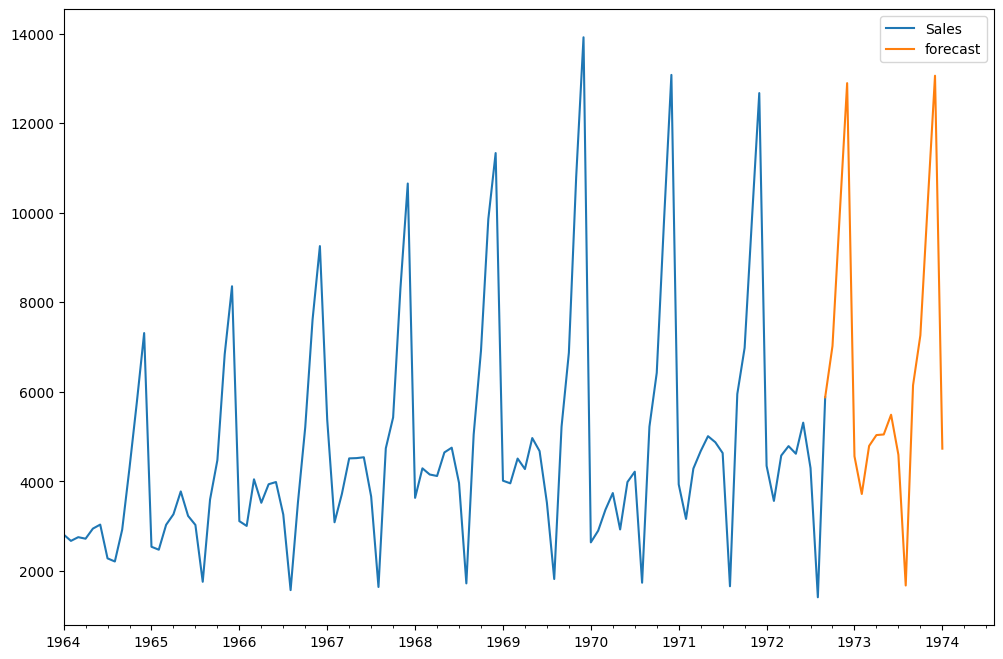

In [210]:
future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)
future_df[['Sales', 'forecast']].plot(figsize=(12, 8))

# Using Different Approach

In [213]:
df=temp_data.copy()
df

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


In [214]:
from datetime import datetime
start_date = datetime(1964,1,1)
end_date = datetime(1972,8,1)

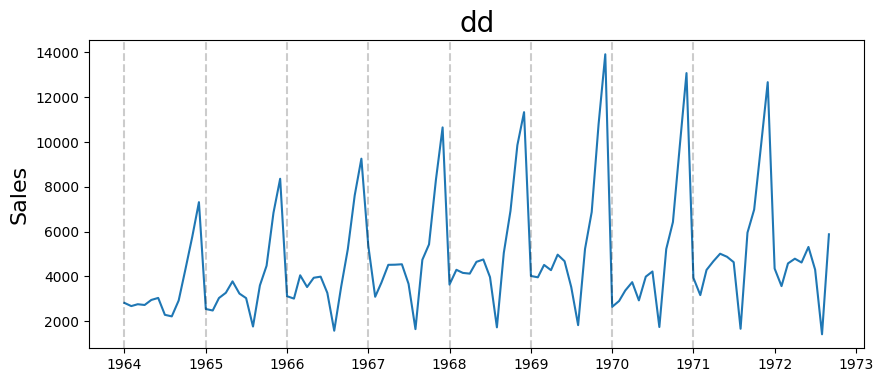

In [215]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.title('dd', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Remove the trend

In [217]:
first_diff = df.diff()[1:]

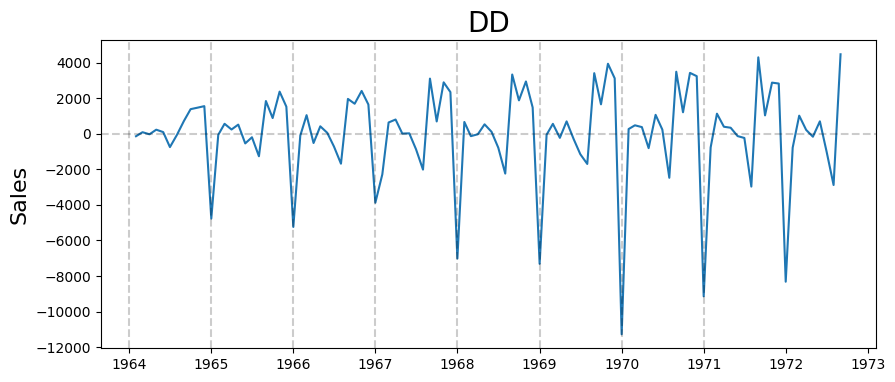

In [218]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('DD', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

Get training and testing sets

In [220]:
from datetime import timedelta

train_end = datetime(1970,1,1)
test_end = datetime(1972,8,1)

test_data = df[train_end + timedelta(days=1):test_end]
test_data.head()

,Sales
Month,
1970-02-01,2899.0
1970-03-01,3370.0
1970-04-01,3740.0
1970-05-01,2927.0
1970-06-01,3986.0


Make Predictions

In [221]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)

In [249]:
rolling_predictions = test_data.copy()
# Initialize a new 'forecast' column with NaN values
rolling_predictions['forecast'] = np.nan

for train_end in test_data.index:
    # train_data consists of all data up to the month *before* train_end
    train_data = df[:train_end - pd.DateOffset(days=1)]

    # Ensure there's enough data to fit the model
    if len(train_data) == 0:
        continue # Skip if no training data is available

    model = SARIMAX(train_data['Sales'], order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit(disp=False) # disp=False to suppress excessive output during fitting

    # forecast() by default predicts one step ahead from the end of train_data
    # The predicted date will be 'train_end'
    pred = model_fit.forecast(steps=1)

    # Assign the scalar predicted value to the 'forecast' column at the 'train_end' index
    rolling_predictions.loc[train_end, 'forecast'] = pred.iloc[0]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

In [250]:
# rolling_predictions = test_data.copy()
# for train_end in test_data.index:
#     train_data = df[:train_end-timedelta(days=1)]
#     model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
#     model_fit = model.fit()

#     pred = model_fit.forecast()
#     rolling_predictions[train_end] = pred

In [251]:
rolling_residuals = test_data['Sales'] - rolling_predictions['forecast']

Text(0, 0.5, 'Error')

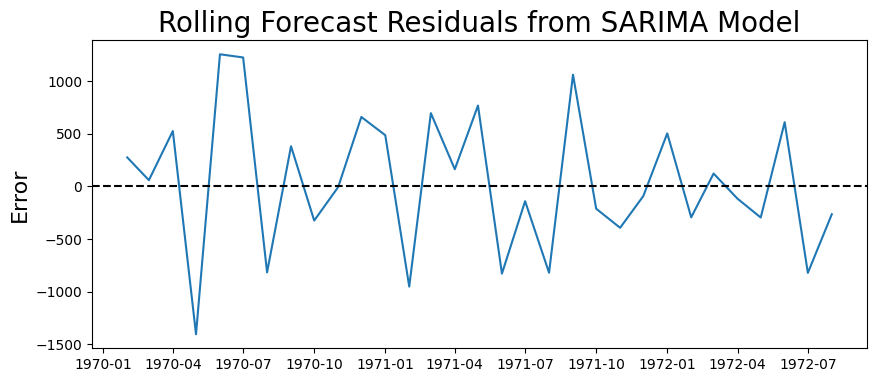

In [252]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

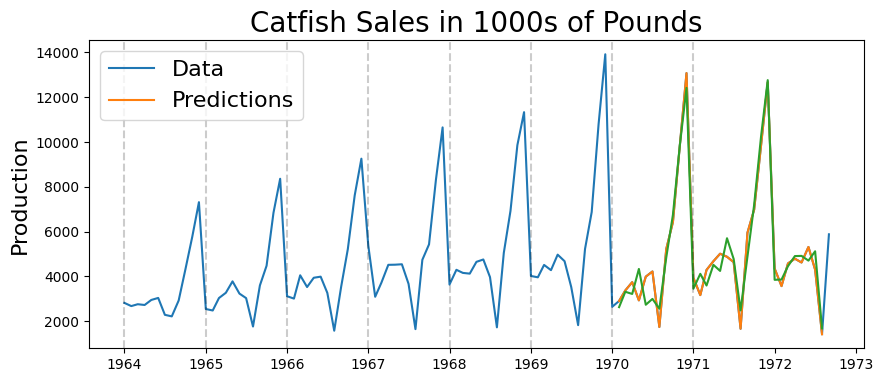

In [253]:
plt.figure(figsize=(10,4))

plt.plot(df)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [256]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data['Sales'])),4))

Mean Absolute Percent Error: 0.1455


In [257]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 654.2036531443125


# Include An ANOMALY

In [258]:
df2=temp_data.copy()

<Axes: xlabel='Month'>

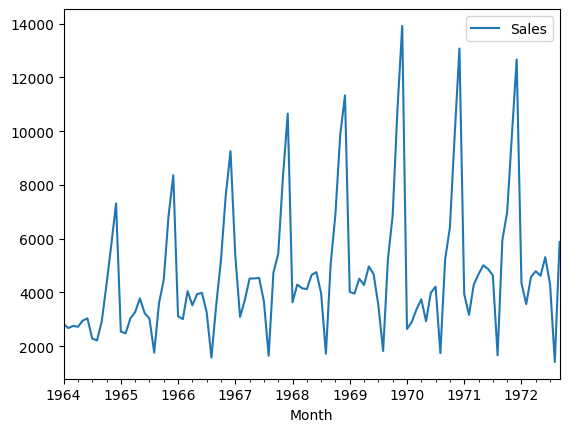

In [259]:
temp_data.plot()

In [260]:
temp_data

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


In [261]:
temp_data.loc[pd.Timestamp('1971-08-01')]

,1971-08-01
Sales,1659.0


In [262]:
print(temp_data.loc['1971-01-01':'1971-12-01'])

              Sales
Month              
1971-01-01   3934.0
1971-02-01   3162.0
1971-03-01   4286.0
1971-04-01   4676.0
1971-05-01   5010.0
1971-06-01   4874.0
1971-07-01   4633.0
1971-08-01   1659.0
1971-09-01   5951.0
1971-10-01   6981.0
1971-11-01   9851.0
1971-12-01  12670.0


<Axes: xlabel='Month'>

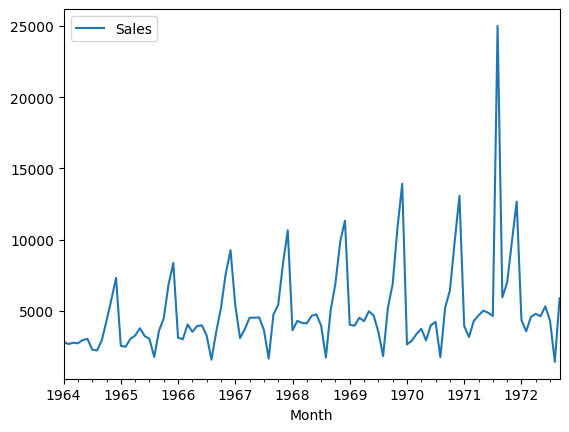

In [263]:
temp_data.loc[pd.Timestamp('1971-08-01'), 'Sales'] = 25000
temp_data.plot()

<Axes: xlabel='Month'>

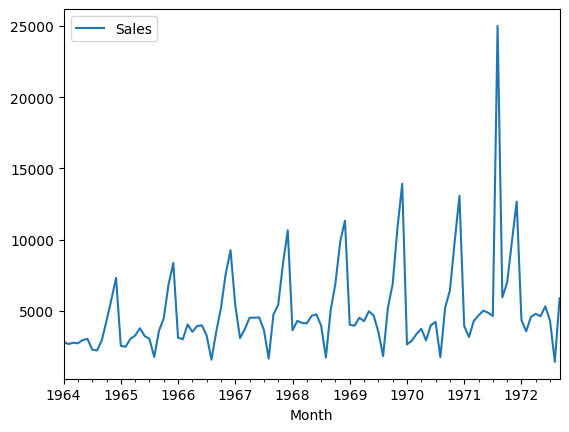

In [264]:
df=temp_data.copy()
df.plot()

In [265]:
adfuller_test(df['Sales'])

ADF Test Statistic : -7.339725392614135
p-value : 1.0730729070942782e-10
#Lags Used : 0
Number of Observations Used : 104
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [266]:
model = ARIMA(df['Sales'], order=(1, 1, 1))
model_fit = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Month'>

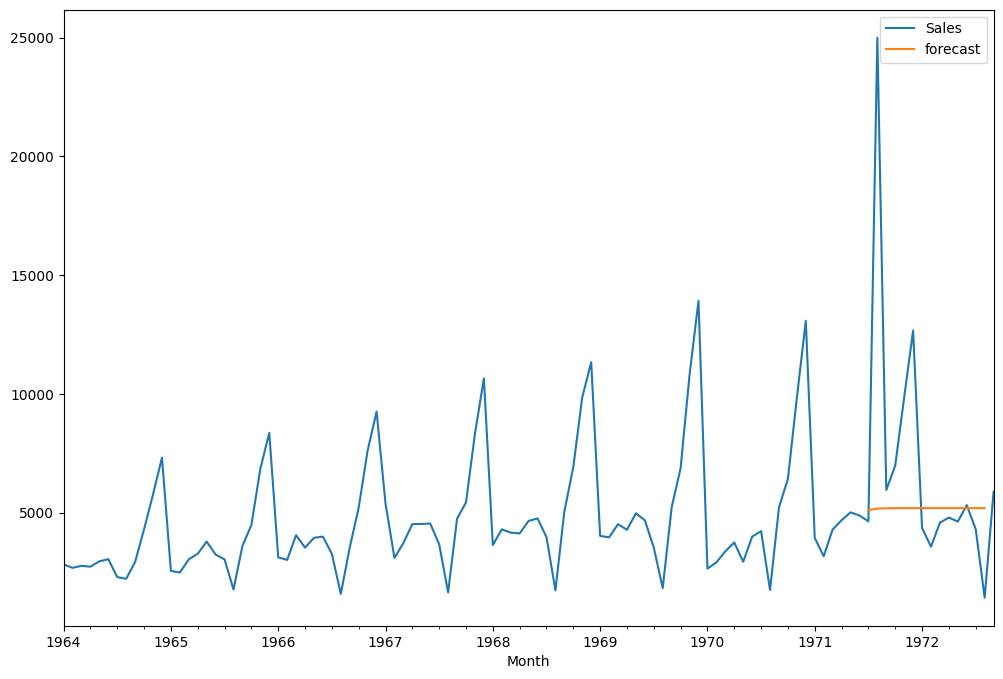

In [267]:
df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

In [268]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Month'>

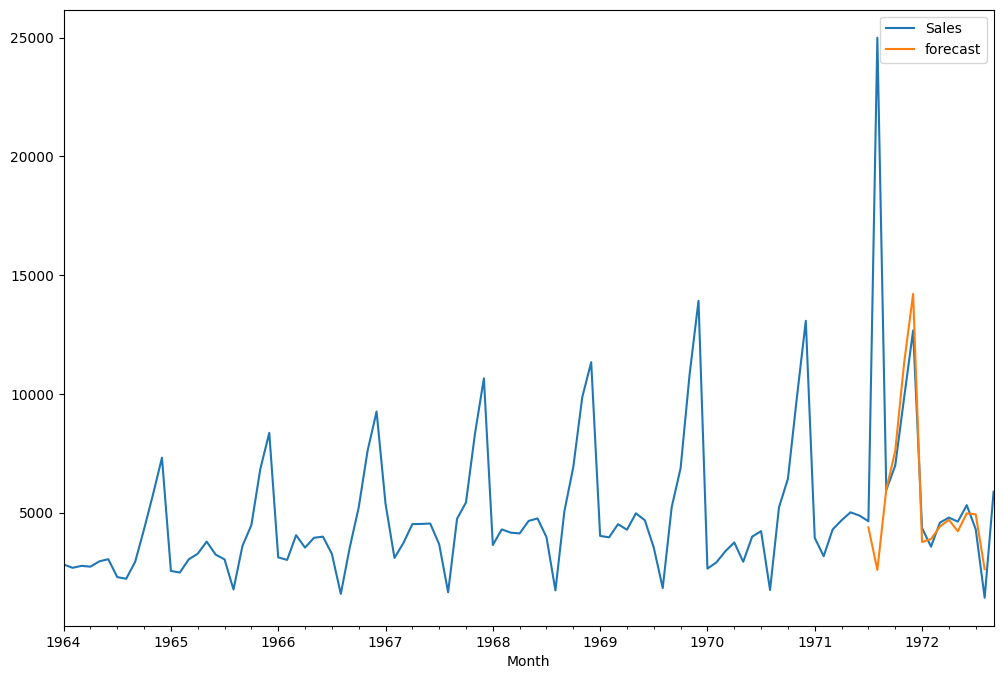

In [269]:
df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

# Detecting the Anomaly

Attempt 1: Deviation Method

In [270]:
df=temp_data.copy()
df

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


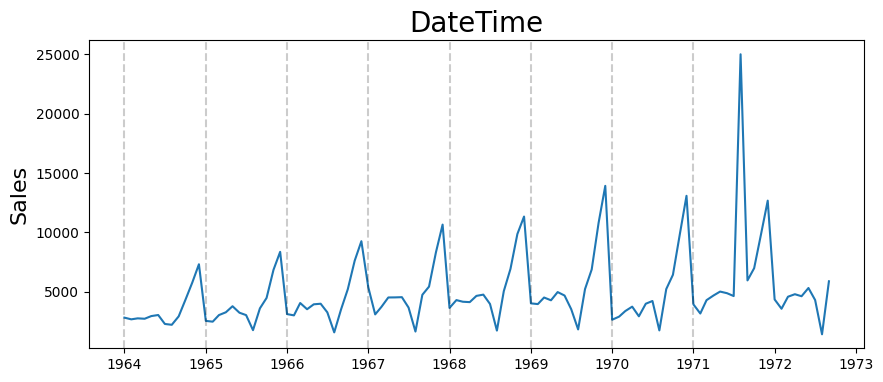

In [271]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.title('DateTime', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [272]:
rolling_deviations = pd.Series(dtype=float, index = df.index)

In [276]:
for date in rolling_deviations.index:
    #get the window ending at this data point
    window = df.loc[:date]

    #get the deviation within this window by looking at the 'Sales' column
    rolling_deviations.loc[date] = window['Sales'].std()

In [277]:
#get the difference in deviation between one time point and the next
diff_rolling_deviations = rolling_deviations.diff()
diff_rolling_deviations = diff_rolling_deviations.dropna()

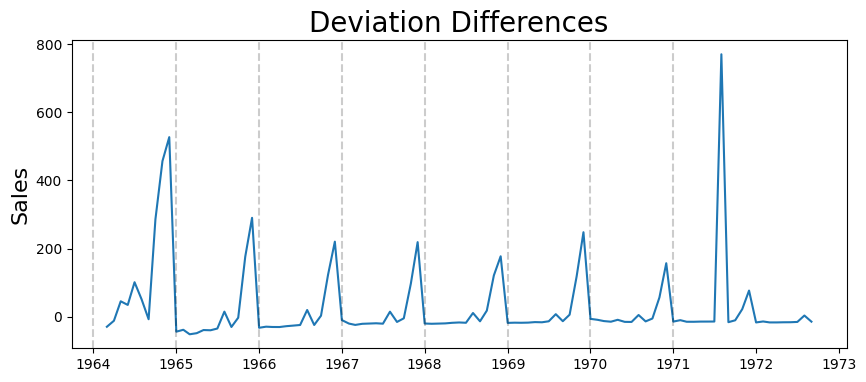

In [278]:
plt.figure(figsize=(10,4))
plt.plot(diff_rolling_deviations)
plt.title('Deviation Differences', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Attempt 2: Seasonal Method

In [279]:
month_deviations = df.groupby(lambda d: d.month).std()

Text(0, 0.5, 'Sales')

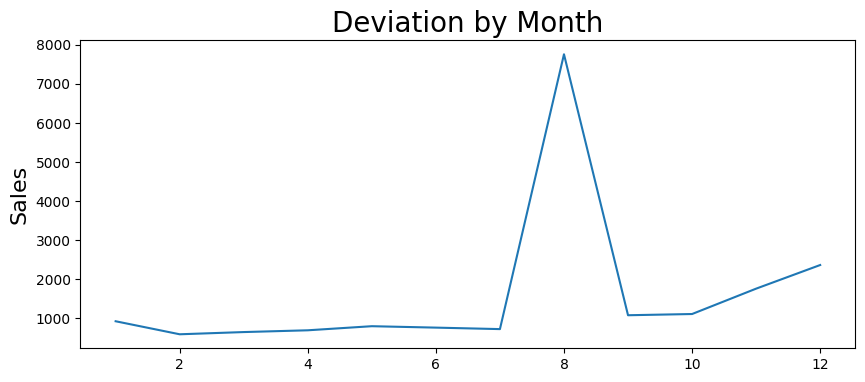

In [280]:
plt.figure(figsize=(10,4))
plt.plot(month_deviations)
plt.title('Deviation by Month', fontsize=20)
plt.ylabel('Sales', fontsize=16)

So, the anomaly occurs in a August

In [281]:
August_data = df[df.index.month == 8]
August_data

,Sales
Month,
1964-08-01,2212.0
1965-08-01,1759.0
1966-08-01,1573.0
1967-08-01,1643.0
1968-08-01,1723.0
1969-08-01,1821.0
1970-08-01,1738.0
1971-08-01,25000.0
1972-08-01,1413.0


In [282]:
min_dev = 9999999
curr_anomaly = None
for date in August_data.index:
    other_data = August_data[August_data.index != date]
    curr_dev = other_data.std()
    if curr_dev.item() < min_dev:
        min_dev = curr_dev.item()
        curr_anomaly = date

In [283]:
print(curr_anomaly)

1971-08-01 00:00:00


# What to do about the anomaly?

In [284]:
adjusted_data = df.copy()
adjusted_data.loc[curr_anomaly] = August_data[(August_data.index != curr_anomaly) &
                                  (August_data.index < test_data.index[0])].mean()

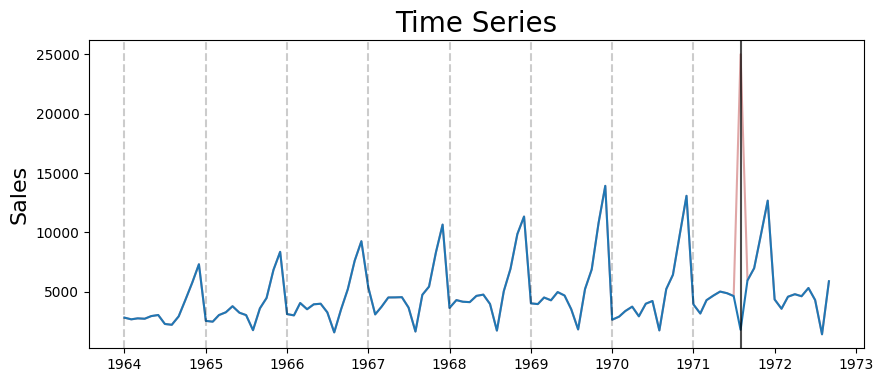

In [285]:
plt.figure(figsize=(10,4))
plt.plot(df, color='firebrick', alpha=0.4)
plt.plot(adjusted_data)
plt.title('Time Series', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(curr_anomaly, color='k', alpha=0.7)